In [23]:
using Random, Distributions, Statistics, Plots, SpecialFunctions, HypothesisTests
using DifferentialEquations, DifferentialEquations.EnsembleAnalysis

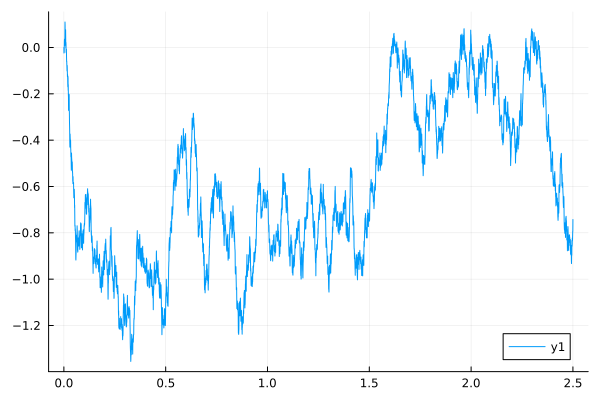

In [24]:
dt = .0005
time_set = 0:dt:2.5
μ = 1.5
σ = .5
W = [0.0]
append!(W, cumsum(rand(Normal(0, sqrt(dt)), length(time_set) - 1)))
plot(time_set, W)

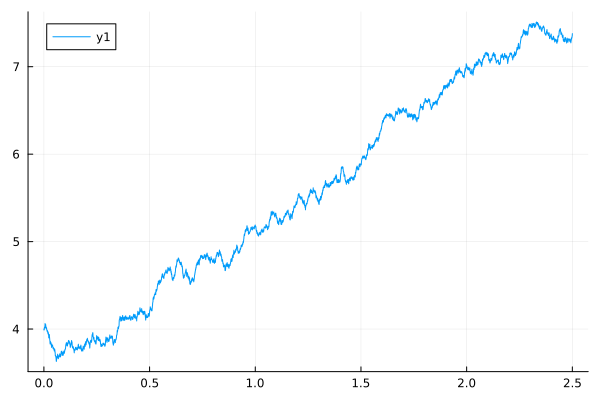

In [25]:
X_uncontrolled = 4 .+ μ * time_set .+ σ * W
plot(time_set, X_uncontrolled)

In [26]:
ε_vec = [1, .5, .1, .05, .01, .005]
skew_point = 6
X_reflected_approx = Matrix{Real}(undef, length(W), length(ε_vec) + 1)
for k in eachindex(ε_vec)
    XX = [4.0]
    for t in eachindex(W)[1:(end - 1)]
        if (XX[end] >= skew_point - ε_vec[k]) & (XX[end] <= skew_point + ε_vec[k])
            push!(XX, XX[end] - σ ^ 2 / (2 * ε_vec[k]) * dt + μ * dt + σ * (W[t + 1] - W[t]))
        else
            push!(XX, XX[end] + μ * dt + σ * (W[t + 1] - W[t]))
        end
    end
    X_reflected_approx[:, k] = XX
end

X_reflected = copy(X_uncontrolled)
for t in eachindex(X_reflected)
    X_reflected[t] = X_reflected[t] .- maximum([0, maximum(X_uncontrolled[1:t] .- 6)])
end

X_reflected_approx[:, length(ε_vec) + 1] = X_reflected
X_reflected_approx

5001×7 Matrix{Real}:
 4.0      4.0      4.0      4.0      4.0      4.0      4.0
 3.98876  3.98876  3.98876  3.98876  3.98876  3.98876  3.98876
 3.99259  3.99259  3.99259  3.99259  3.99259  3.99259  3.99259
 3.99127  3.99127  3.99127  3.99127  3.99127  3.99127  3.99127
 4.0063   4.0063   4.0063   4.0063   4.0063   4.0063   4.0063
 4.01817  4.01817  4.01817  4.01817  4.01817  4.01817  4.01817
 4.02243  4.02243  4.02243  4.02243  4.02243  4.02243  4.02243
 4.01797  4.01797  4.01797  4.01797  4.01797  4.01797  4.01797
 4.01645  4.01645  4.01645  4.01645  4.01645  4.01645  4.01645
 4.01104  4.01104  4.01104  4.01104  4.01104  4.01104  4.01104
 4.03383  4.03383  4.03383  4.03383  4.03383  4.03383  4.03383
 4.06324  4.06324  4.06324  4.06324  4.06324  4.06324  4.06324
 4.05711  4.05711  4.05711  4.05711  4.05711  4.05711  4.05711
 ⋮                                            ⋮        
 7.13431  7.14125  7.18912  7.11725  7.27475  7.281    5.78187
 7.16653  7.17347  7.22134  7.14947  7.30697  

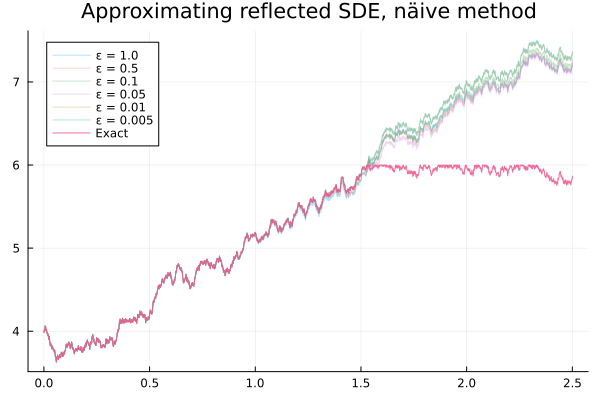

In [27]:
lab = ["ε = $k" for k in ε_vec]
α = repeat([.3], length(ε_vec))
push!(α, .9)
push!(lab, "Exact")
pp = plot(time_set, X_reflected_approx, label = hcat(lab...), alpha = hcat(α...), title = "Approximating reflected SDE, näive method")

In [28]:
Plots.pdf(pp, "Naive_approx.pdf")

"Naive_approx.pdf"

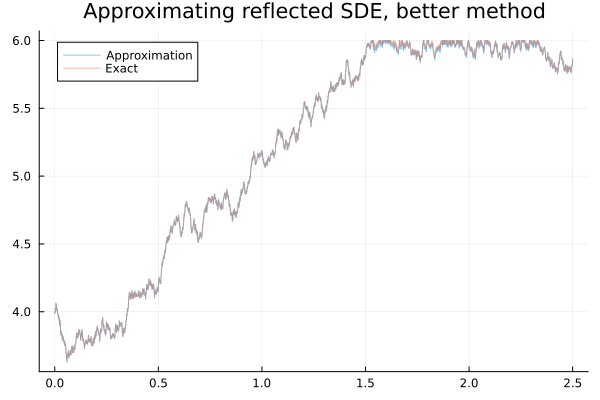

In [29]:
skew_point = 6
X_reflected_approx_better = Matrix{Real}(undef, length(W), 2)
XX = [4.0]
L = [0.0]
for t in eachindex(W)[1:(end - 1)]
    next_step_appr = XX[end] + μ * dt + σ * (W[t + 1] - W[t])
    if ((XX[end] >= skew_point) & (next_step_appr <= skew_point)) | ((XX[end] <= skew_point) & (next_step_appr >= skew_point))
        push!(L, L[end] + abs(next_step_appr - skew_point))
        push!(XX, next_step_appr - (L[end] - L[end - 1]))
    else
        push!(L, L[end])
        push!(XX, next_step_appr)
    end
end
X_reflected_approx_better[:, 1] = XX

X_reflected = copy(X_uncontrolled)
for t in eachindex(X_reflected)
    X_reflected[t] = X_reflected[t] .- maximum([0, maximum(X_uncontrolled[1:t] .- 6)])
end

X_reflected_approx_better[:, 2] = X_reflected
X_reflected_approx_better
pp = plot(time_set, X_reflected_approx_better, label = ["Approximation" "Exact"], title = "Approximating reflected SDE, better method", alpha = .5)

In [30]:
Plots.pdf(pp, "Better_approx.pdf")

"Better_approx.pdf"

In [31]:
ε_vec = [1, .5, .1, .05, .01, .005]
skew_point = 6
intensity = .75
X_skew_approx = Matrix{Real}(undef, length(W), length(ε_vec) + 1)
for k in eachindex(ε_vec)
    XX = [4.0]
    for t in eachindex(W)[1:(end - 1)]
        if (XX[end] >= skew_point - ε_vec[k]) & (XX[end] <= skew_point + ε_vec[k])
            push!(XX, XX[end] - intensity *  σ ^ 2 / (2 * ε_vec[k]) * dt + μ * dt + σ * (W[t + 1] - W[t]))
        else
            push!(XX, XX[end] + μ * dt + σ * (W[t + 1] - W[t]))
        end
    end
    X_skew_approx[:, k] = XX
end

XX = [4.0]
L = [0.0]
for t in eachindex(W)[1:(end - 1)]
    next_step_appr = XX[end] + μ * dt + σ * (W[t + 1] - W[t])
    if ((XX[end] >= skew_point) & (next_step_appr <= skew_point)) | ((XX[end] <= skew_point) & (next_step_appr >= skew_point))
        push!(L, L[end] +  abs(next_step_appr - skew_point))
        push!(XX, next_step_appr - (L[end] - L[end - 1]) * intensity)
    else
        push!(L, L[end])
        push!(XX, next_step_appr)
    end
end
X_skew_approx[:, length(ε_vec) + 1] = XX
X_skew_approx

5001×7 Matrix{Real}:
 4.0      4.0      4.0      4.0      4.0      4.0      4.0
 3.98876  3.98876  3.98876  3.98876  3.98876  3.98876  3.98876
 3.99259  3.99259  3.99259  3.99259  3.99259  3.99259  3.99259
 3.99127  3.99127  3.99127  3.99127  3.99127  3.99127  3.99127
 4.0063   4.0063   4.0063   4.0063   4.0063   4.0063   4.0063
 4.01817  4.01817  4.01817  4.01817  4.01817  4.01817  4.01817
 4.02243  4.02243  4.02243  4.02243  4.02243  4.02243  4.02243
 4.01797  4.01797  4.01797  4.01797  4.01797  4.01797  4.01797
 4.01645  4.01645  4.01645  4.01645  4.01645  4.01645  4.01645
 4.01104  4.01104  4.01104  4.01104  4.01104  4.01104  4.01104
 4.03383  4.03383  4.03383  4.03383  4.03383  4.03383  4.03383
 4.06324  4.06324  4.06324  4.06324  4.06324  4.06324  4.06324
 4.05711  4.05711  4.05711  4.05711  4.05711  4.05711  4.05711
 ⋮                                            ⋮        
 7.181    7.184    7.226    7.20537  7.27475  7.28412  7.29338
 7.21322  7.21622  7.25822  7.23759  7.30697  

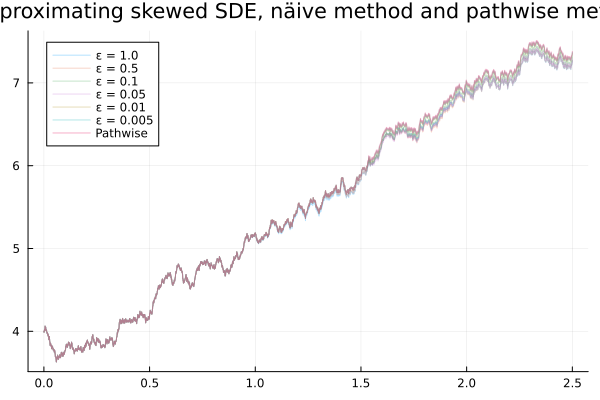

In [32]:
lab = ["ε = $k" for k in ε_vec]
α = repeat([.3], length(ε_vec))
push!(α, .5)
push!(lab, "Pathwise")
pp = plot(time_set, X_skew_approx, label = hcat(lab...), alpha = hcat(α...), title = "Approximating skewed SDE, näive method and pathwise method")

In [33]:
Plots.pdf(pp, "skewed_approx.pdf")

"skewed_approx.pdf"